## Task Bonus: CT Reconstruction of a Slice 

As we understood, we can apply the central slice theorem in this case. This theorem defends the idea that the Fourier transform in 2D of our image along a line (a spike in the MRI case) can be seen as the 1D Fourier transform of the Radon Transform (integral over the line of our object for a theta). In our case, we already have the 2D Fourier transform of each line in radial sampling, and we want to get the "Radon Transform" in order to filter (not totaly sure bc maybe we already did it with the density compensation) and back project it (maybe using FBP).

Let us refer to the one-dimensional (1D) inverse Fourier transform (of each spike) in the radial direction of the k-space measurements as the sinogram. After that, we can just think of our problem as a CT reconstruction situation, where we can reconstruct the image starting from the sinogram. The image reconstruction algorithm is chosen as the FBP algorithm.

https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html

In [10]:
# Task 1 - Import libraries
%matplotlib notebook
import SimpleITK as sitk
import numpy as np
import sigpy as sp
from sigpy.mri import samp
import sigpy.plot as pl
from scipy import ndimage as ndi

import os
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from skimage.transform import resize
import time
import math
from skimage.io import imread
from scipy.signal import convolve2d
from skimage import color, data, restoration, filters, measure
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from skimage.transform import iradon

import pywt
from scipy.ndimage.filters import convolve
import cv2

C:\Users\rebec\AppData\Local\Temp\ipykernel_13196\455036012.py:25: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [11]:
# Needed function
def fftc_2d(_data):
    data = _data.copy()
    data = np.fft.ifftshift(data)
    data = np.fft.fft2(data, norm="ortho")
    return np.fft.fftshift(data)    

def ifftc_2d(_data):
    data = _data.copy()
    data = np.fft.ifftshift(data)
    data = np.fft.ifft2(data, norm="ortho")
    return np.fft.fftshift(data)    

def show_image(image,title):
    plt.figure()
    plt.imshow(np.abs(image))#, cmap='gray') # If we want them in grayscale from the beginning
    plt.title(title, size=16)
    plt.show()

def show_kspace(kspace,title):
    plt.figure()
    plt.imshow(np.log(np.abs(kspace)))#, cmap='gray')
    plt.title(title, size=16)
    plt.show()
    
def Normalization(_original, _reconstructed):
    _orig_norm = np.abs(_original- np.min(_original))/np.abs(np.max(_original) - np.min(_original))
    _rec_norm = np.abs(_reconstructed- np.min(_reconstructed))/np.abs(np.max(_reconstructed) - np.min(_reconstructed)) 
    #_orig_norm = np.abs(_original)/(np.max(np.abs(_original)))
    #_rec_norm = np.abs(_reconstructed)/(np.max(np.abs(_reconstructed)))
    '''plt.imshow(_rec_norm)
    plt.title('reconstructed normalized')
    plt.show()
    plt.imshow(_orig_norm)
    plt.title('original normalized')
    plt.show()'''
    return _orig_norm, _rec_norm

def Quantitative_f(_original, _reconstructed):
    SSIM = ssim(_original, _reconstructed)
    print("SSIM:", SSIM)
    PSNR = psnr(_original, _reconstructed) # returns dB value
    print("PSNR:", PSNR)
    MSE = mse(_original, _reconstructed)
    print("MSE:", MSE)
    return SSIM, PSNR, MSE

In [12]:
# Read image - MRI brain

sitk_t1 = sitk.ReadImage('t1.nii.gz')
sz_img = sitk_t1.GetSize()
#print(sz_img) # Real size of our image - (256, 256, 90, 1, 2)
              # I have 90 slices of a 256x256 matrix
t1_data = sitk.GetArrayFromImage(sitk_t1)
print(np.shape(t1_data))


sz_img_ndarray = np.shape(t1_data) # size of the transpose matrix - (2, 1, 90, 256, 256)
#print(sz_img_ndarray)

t1_data_transpose = np.transpose(t1_data)
#print(np.shape(t1_data_transpose))

# Central Slice: 45
slice_img = t1_data[0,0,int(sz_img_ndarray[2]/2),:,:]


# Cartesian sampling - Kspace
kspace_cart = fftc_2d(slice_img)
image_cart = ifftc_2d(kspace_cart)

(2, 1, 90, 256, 256)


128
(64, 512)


<IPython.core.display.Javascript object>


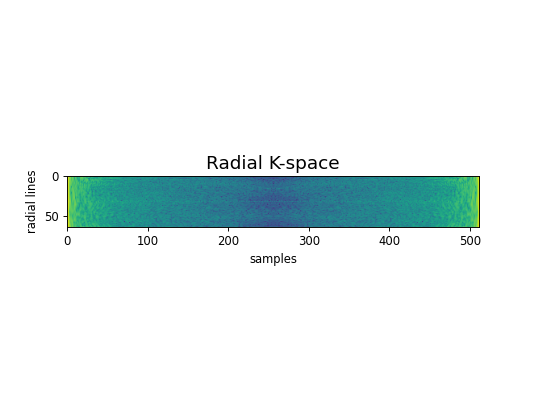

(64, 512)
(64, 512)


<IPython.core.display.Javascript object>


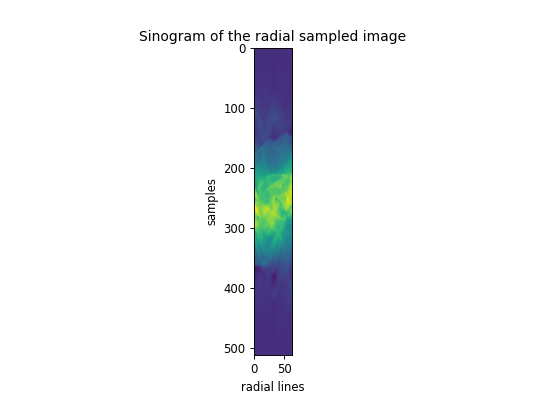

In [13]:
# Sinogram - 1D FT over spike
# NOTE: Pay attention to select an even number of spikes! 
R=2
spikes = int(np.round(256/R))
print(spikes)
# golden = False in order to obtain equispaced spikes
coord_radial = sp.mri.radial([spikes,256,2],[256,256], golden = False)

# Now, we use this coordinates to select the values in the k-space and use it to reconstruct the image
kspace_rad_off = sp.interpolate(kspace_cart, coord_radial +int(256/2)) # In the example code, they use some offset
dcf_rad = (coord_radial[..., 0]**2 + coord_radial[..., 1]**2)**0.5

# concatenation of 'opposite' spikes --> we realized that a spike it's just half of the line: it means that the fourier
# transform 1D has to be done along an entire line or in other words along the concatenation of two opposite spikes. 
kspace_reshape =[]
m = int(kspace_rad_off.shape[0]/2)
for i in range(m):
    arr= np.concatenate((kspace_rad_off[i,:],np.flip(kspace_rad_off[m+i,:])), axis = 0)
    kspace_reshape.append(arr)

kspace_reshape = np.array(kspace_reshape)
print(kspace_reshape.shape)

plt.figure()
plt.imshow(np.log(np.abs(kspace_reshape)))#, cmap='gray')
plt.title('Radial K-space', size=16)
plt.xlabel('samples')
plt.ylabel('radial lines')
plt.show()

# Sinogram 
sinogram = []
for i in range(int(spikes/2)):
    sinogram.append(np.fft.fftshift(np.fft.ifft(kspace_reshape[i,:])))
    
print(np.shape(sinogram))
print(np.array(sinogram).shape)
# each column is a spike (or a specific angle of acquisition)
sinogram = np.transpose(np.array((sinogram))) 
plt.figure()
plt.imshow(np.real(sinogram))
plt.title('Sinogram of the radial sampled image')
plt.xlabel('radial lines')
plt.ylabel('samples')
plt.show()

FBP rms reconstruction error: 0.185
SSIM: 0.3680095947004073
PSNR: 14.640381920535155
MSE: 0.03435277365866895


<IPython.core.display.Javascript object>


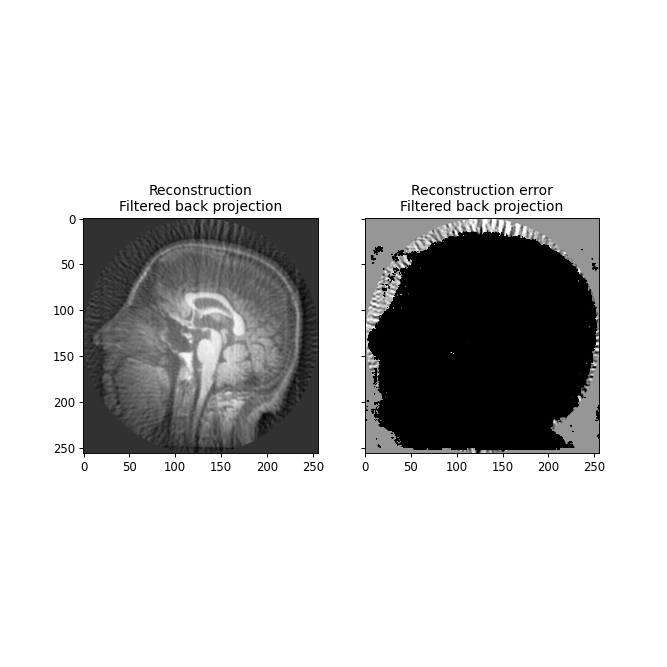

In [15]:
# Now we apply the FBP to our sinogram

theta = np.linspace(0,-180,num=int(spikes/2)) #
reconstruction_fbp = iradon((np.array(sinogram)), theta=theta, output_size=256, filter_name='hamming')
reconstruction_fbp_norm, slice_img_norm = Normalization(slice_img, reconstruction_fbp)
error = reconstruction_fbp_norm - np.abs(slice_img_norm)
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')
SSIM, PSNR, MSE = Quantitative_f(slice_img_norm, reconstruction_fbp_norm)

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - np.abs(slice_img), cmap=plt.cm.Greys_r, **imkwargs)
plt.show()